## Detectability

In [72]:
import json
import textwrap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

### Load data

In [73]:
def load_data(path: str):
    with open(path) as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)

    if "_id" in df.columns:
        df = df.drop(columns="_id")

    return df

unobfuscated_unoptimized = load_data("./data/unoptimized/unobfuscated.json")
unobfuscated_optimized = load_data("./data/optimized/unobfuscated.json")

tigress_unoptimized = load_data("./data/unoptimized/tigress.json")
tigress_optimized = load_data("./data/optimized/tigress.json")

llvm_unoptimized = load_data("./data/unoptimized/llvm.json")
llvm_optimized = load_data("./data/optimized/llvm.json")

wasm_mutate_unoptimized = load_data("./data/unoptimized/wasm-mutate.json")
wasm_mutate_optimized = load_data("./data/optimized/wasm-mutate.json")
wasm_mutate_experiment = load_data("./data/unoptimized/wasm-mutate-fn.json")

wasm_mutate_unoptimized['transformation'] = wasm_mutate_unoptimized['mutator']
wasm_mutate_optimized['transformation'] = wasm_mutate_optimized['mutator']
wasm_mutate_experiment['transformation'] = wasm_mutate_experiment['mutator']

In [74]:
transformation_label_map = {
    "flatten": "Flattening",
    "randomfuns": "Random Functions",
    "encodearithmetic": "Encode Arithmetic",
    "encodeliterals": "Encode Literals",
    "split": "Function Splitting",
    "virtualize": "Virtualization",
    "antitaintanalysis": "Anti Taint Analysis",
    "antialiasanalysis": "Anti Alias Analysis"
}

# Create a new column 'transformation_label' based on the 'transformation' column values
tigress_unoptimized['transformation'] = tigress_unoptimized['transformation'].map(transformation_label_map)
tigress_optimized['transformation'] = tigress_optimized['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'transformation' column values
transformation_label_map = {
    "cffobf": "Control Flow Flattening",
    "bcfobf": "Bogus Control Flow",
    "constenc": "Constants Encryption",
    "strcry": "String Encryption",
    "splitobf": "Basic Block Splitting",
    "indibran": "Indirect Branches",
    "subobf": "Substitute Instruction",
    "funcwra": "Function Wrapper"
}
llvm_unoptimized['transformation'] = llvm_unoptimized['transformation'].map(transformation_label_map)
llvm_optimized['transformation'] = llvm_optimized['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'mutator' column values
wasm_mutate_unoptimized['transformation'] = wasm_mutate_unoptimized['mutator']
wasm_mutate_optimized['transformation'] = wasm_mutate_optimized['mutator']
wasm_mutate_experiment['transformation'] = wasm_mutate_experiment['mutator']
transformation_label_map = {
    "AddCustomSectionMutator": "Add Custom Section",
    "PeepholeMutator": "Peephole",
    "CodemotionMutator": "Code Motion",
    "AddTypeMutator": "Add Type",
    "AddFunctionMutator": "Add Function",
    "RemoveSection": "Remove Section",
    "RemoveItemMutator": "Remove Item",
    "ReorderCustomSectionMutator": "Reorder Custom Section", 
    "CustomSectionMutator": "Custom Section"
}
wasm_mutate_unoptimized['transformation'] = wasm_mutate_unoptimized['transformation'].map(transformation_label_map)
wasm_mutate_optimized['transformation'] = wasm_mutate_optimized['transformation'].map(transformation_label_map)
wasm_mutate_experiment['transformation'] = wasm_mutate_experiment['transformation'].map(transformation_label_map)

In [75]:
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.2,
    rc = {
      "figure.figsize": (10, 6),
      "errorbar.capsize": 0.05,
      "xtick.color": "#646464",
      "ytick.color": "#646464",
      "legend.loc": "best",
      "font.family": "Ubuntu",
    }
)

palette = "tab20"
edgecolor = "#646464"
errwidth = 1.8
capsize = 0.05

blues = sns.color_palette("Blues", n_colors= 1)
greens = sns.color_palette("Greens", n_colors=1)
reds = sns.color_palette("Reds", n_colors=1)

bgr_palette = blues + greens + reds
grb_palette = greens + reds + blues

### Extract detection results

In [76]:
def extract_detection_results(df, optimization, obfuscation=None):
    # Extracting the minos, miner_ray, virustotal, and wasim result values
    df["minos_result"] = df["minos"].apply(lambda x: x["result"])
    df["miner_ray_result"] = df["miner_ray"].apply(lambda x: x["result"])
    df["virustotal_result"] = df["virustotal"].apply(lambda x: x["result"])

    # Extracting wasim results
    def extract_wasim_cryptominer(model_results):
        model_results = {k: v for k, v in model_results.items() if k != "code"}
        sorted_results = sorted(model_results.items(), key=lambda x: x[1], reverse=True)
        return int(sorted_results[0][0] == "Cryptominer")

    df["wasim_neural"] = df["wasim"].apply(lambda x: extract_wasim_cryptominer(x["result"]["neural"]))
    df["wasim_random"] = df["wasim"].apply(lambda x: extract_wasim_cryptominer(x["result"]["random"]))
    df["wasim_svm"] = df["wasim"].apply(lambda x: extract_wasim_cryptominer(x["result"]["svm"]))
    df["wasim_naive"] = df["wasim"].apply(lambda x: extract_wasim_cryptominer(x["result"]["naive"]))

    df["ground_truth"] = df["category"].apply(lambda x: 1 if x == "miners" else 0)


    # Check if 'transformation' column exists
    if "transformation" in df.columns:
        transformation_column = df["transformation"]
    else:
        transformation_column = [None] * len(df)

    # Creating the new DataFrame with the specified columns
    detection_results_df = pd.DataFrame(
        {
            "obfuscation": [obfuscation] * len(df),
            "optimization": [optimization] * len(df),
            "transformation": transformation_column,
            "name": df["name"],
            "ground_truth": df["ground_truth"],
            "minos": df["minos_result"],
            "miner_ray": df["miner_ray_result"],
            "virustotal": df["virustotal_result"],
            "wasim_neural": df["wasim_neural"],
            "wasim_random": df["wasim_random"],
            "wasim_svm": df["wasim_svm"],
            "wasim_naive": df["wasim_naive"],
        }
    )

    return detection_results_df

#### Combine into one dataframe

In [77]:
unobfuscated_unoptimized_results = extract_detection_results(unobfuscated_unoptimized, optimization="unoptimized")
unobfuscated_optimized_results = extract_detection_results(unobfuscated_optimized, optimization="optimized")

tigress_unoptimized_results = extract_detection_results(tigress_unoptimized, optimization="unoptimized", obfuscation="Tigress")
tigress_optimized_results = extract_detection_results(tigress_optimized, optimization="optimized", obfuscation="Tigress")

llvm_unoptimized_results = extract_detection_results(llvm_unoptimized, optimization="unoptimized", obfuscation="llvm")
llvm_optimized_results = extract_detection_results(llvm_optimized, optimization="optimized", obfuscation="llvm")

filtered_wasm_mutate_data_unoptimized = wasm_mutate_unoptimized[wasm_mutate_unoptimized['miner_ray'].notna()]
filtered_wasm_mutate_data_optimized = wasm_mutate_optimized[wasm_mutate_optimized['miner_ray'].notna()]

filtered_wasm_mutate_data_unoptimized["transformation"] = filtered_wasm_mutate_data_unoptimized.apply(lambda row: f"Iteration {row['iteration']}" if row['iteration'] % 100 == 0 else row['transformation'], axis=1)
filtered_wasm_mutate_data_optimized["transformation"] = filtered_wasm_mutate_data_optimized.apply(lambda row: f"Iteration {row['iteration']}" if row['iteration'] % 100 == 0 else row['transformation'], axis=1)

wasm_mutate_unoptimized_results = extract_detection_results(filtered_wasm_mutate_data_unoptimized, optimization="unoptimized", obfuscation="wasm-mutate")
wasm_mutate_optimized_results = extract_detection_results(filtered_wasm_mutate_data_optimized, optimization="optimized", obfuscation="wasm-mutate")

df = pd.concat([unobfuscated_unoptimized_results, unobfuscated_optimized_results, tigress_unoptimized_results, tigress_optimized_results, llvm_unoptimized_results, llvm_optimized_results, wasm_mutate_unoptimized_results, wasm_mutate_optimized_results], ignore_index=True)
df_unoptimized = pd.concat([unobfuscated_unoptimized_results, tigress_unoptimized_results, llvm_unoptimized_results, wasm_mutate_unoptimized_results], ignore_index=True)

df

/tmp/ipykernel_24729/2204795460.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data_unoptimized["transformation"] = filtered_wasm_mutate_data_unoptimized.apply(lambda row: f"Iteration {row['iteration']}" if row['iteration'] % 100 == 0 else row['transformation'], axis=1)
/tmp/ipykernel_24729/2204795460.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data_optimized["transformation"] = filtered_wasm_mutate_data_optimized.apply(lambda row: f"Iteration {row['i

,obfuscation,optimization,transformation,name,ground_truth,minos,miner_ray,virustotal,wasim_neural,wasim_random,wasim_svm,wasim_naive
0,None,unoptimized,None,wgsim,0,0,0,0,0,0,0,0
1,None,unoptimized,None,tree,0,0,0,0,0,0,0,0
2,None,unoptimized,None,f1-race,0,0,0,0,0,0,0,0
3,None,unoptimized,None,game-of-life,0,0,0,0,0,0,0,0
4,None,unoptimized,None,wasm-asteroids,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1407,wasm-mutate,optimized,Iteration 700,cn-lite-2,1,1,0,0,0,1,0,0
1408,wasm-mutate,optimized,Iteration 500,cn-lite-2,1,1,0,0,0,1,0,0
1409,wasm-mutate,optimized,Iteration 800,cn-lite-2,1,1,0,0,1,1,0,0
1410,wasm-mutate,optimized,Iteration 900,cn-lite-2,1,1,0,0,1,1,0,0


#### Detailed performance per detection method

In [78]:
def evaluate_method(df, method):
    
    # Calculate true positive (TP), false positive (FP), false negative (FN), and true negative (TN)
    TP = sum((df[method] == 1) & (df["ground_truth"] == 1))
    FP = sum((df[method] == 1) & (df["ground_truth"] == 0))
    FN = sum((df[method] == 0) & (df["ground_truth"] == 1))
    TN = sum((df[method] == 0) & (df["ground_truth"] == 0))
    
    # Calculate precision, recall, and F1-score
    precision = round(TP / (TP + FP) if TP + FP > 0 else 0, 2)
    recall = round(TP / (TP + FN) if TP + FN > 0 else 0, 2)
    f1_score = round((2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0, 2)
    
    # Calculate Matthews Correlation Coefficient (MCC)
    mcc_numerator = (TP * TN) - (FP * FN)
    mcc_denominator = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    mcc = round(mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0, 2)
    
    return precision, recall, f1_score, mcc



def calculate_metrics_by_method(df, method):

    # Calculate the evaluation metrics for each subset
    metrics = evaluate_method(df, method)

    # Create a new DataFrame with the evaluation metrics
    metrics_df = pd.DataFrame(
        {
            "obfuscation": [None],
            "transformation": [None],
            f"{method}_precision": [metrics[0]],
            f"{method}_recall": [metrics[1]],
            f"{method}_f1_score": [metrics[2]],
        }
    )

    return metrics_df


def calculate_metrics_by_obfuscation_and_method(df, method):
    # Find unique obfuscation methods and transformations
    unique_obfuscations = df["obfuscation"].dropna().unique()
    unique_transformations = df["transformation"].dropna().unique()
    
    metrics_df_list = []
    
    # Handle the case without obfuscation
    no_obfuscation_df = df[df["obfuscation"].isna()]
    no_obfuscation_metrics = calculate_metrics_by_method(no_obfuscation_df, method)
    metrics_df_list.append(no_obfuscation_metrics)

    # Iterate over obfuscation methods and transformations, calculating metrics for each combination
    for obfuscation in unique_obfuscations:
        for transformation in unique_transformations:
            filtered_df = df[(df["obfuscation"] == obfuscation) & (df["transformation"] == transformation)]
            if len(filtered_df) > 0:
                obfuscation_transformation_metrics = calculate_metrics_by_method(filtered_df, method)
                obfuscation_transformation_metrics["obfuscation"] = obfuscation
                obfuscation_transformation_metrics["transformation"] = transformation
                metrics_df_list.append(obfuscation_transformation_metrics)
    
    # Concatenate all DataFrames in the list
    metrics_df = pd.concat(metrics_df_list, ignore_index=True)
    return metrics_df


minos_metrics = calculate_metrics_by_obfuscation_and_method(df_unoptimized, "minos")
wasim_metrics = calculate_metrics_by_obfuscation_and_method(df_unoptimized, "wasim_neural")

combined_metrics = minos_metrics 
combined_metrics["wasim_recall"] = wasim_metrics["wasim_neural_recall"]
combined_metrics["wasim_precision"] = wasim_metrics["wasim_neural_precision"]
combined_metrics["wasim_f1_score"] = wasim_metrics["wasim_neural_f1_score"]

latex_table = combined_metrics.to_latex(index=False)
minos_metrics


,obfuscation,transformation,minos_precision,minos_recall,minos_f1_score,wasim_recall,wasim_precision,wasim_f1_score
0,None,None,1.00,1.0,1.00,0.2,1.00,0.33
1,Tigress,Encode Arithmetic,0.58,0.7,0.63,0.7,0.78,0.74
2,Tigress,Function Splitting,0.40,0.2,0.27,1.0,0.91,0.95
3,Tigress,Random Functions,0.71,1.0,0.83,1.0,0.91,0.95
4,Tigress,Flattening,0.67,1.0,0.80,0.0,0.00,0.00
5,Tigress,Encode Literals,0.56,1.0,0.72,1.0,0.83,0.91
6,Tigress,Anti Taint Analysis,0.77,1.0,0.87,0.8,0.89,0.84
7,Tigress,Anti Alias Analysis,0.00,0.0,0.00,0.0,0.00,0.00
8,Tigress,Virtualization,0.75,0.9,0.82,0.0,0.00,0.00
9,llvm,Control Flow Flattening,0.67,1.0,0.80,0.0,0.00,0.00


#### Detailed performance per detection methods by optimization

In [79]:
def evaluate_method(df, method):
    
    # Calculate true positive (TP), false positive (FP), false negative (FN), and true negative (TN)
    TP = sum((df[method] == 1) & (df["ground_truth"] == 1))
    FP = sum((df[method] == 1) & (df["ground_truth"] == 0))
    FN = sum((df[method] == 0) & (df["ground_truth"] == 1))
    TN = sum((df[method] == 0) & (df["ground_truth"] == 0))
    
    # Calculate precision, recall, and F1-score
    precision = round(TP / (TP + FP) if TP + FP > 0 else 0, 2)
    recall = round(TP / (TP + FN) if TP + FN > 0 else 0, 2)
    f1_score = round((2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0, 2)
    
    # Calculate Matthews Correlation Coefficient (MCC)
    mcc_numerator = (TP * TN) - (FP * FN)
    mcc_denominator = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    mcc = round(mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0, 2)
    
    return precision, recall, f1_score, mcc



def calculate_metrics_by_optimization(df, method):
    # Split the data into unoptimized and optimized subsets
    unoptimized_df = df[df["optimization"] == "unoptimized"]
    optimized_df = df[df["optimization"] == "optimized"]

    # Calculate the evaluation metrics for each subset
    unoptimized_metrics = evaluate_method(unoptimized_df, method)
    optimized_metrics = evaluate_method(optimized_df, method)

    # Create a new DataFrame with the evaluation metrics
    metrics_df = pd.DataFrame(
        {
            "obfuscation": [None],
            "transformation": [None],
            f"unoptimized_{method}_precision": [unoptimized_metrics[0]],
            f"unoptimized_{method}_recall": [unoptimized_metrics[1]],
            f"unoptimized_{method}_f1_score": [unoptimized_metrics[2]],
            f"optimized_{method}_precision": [optimized_metrics[0]],
            f"optimized_{method}_recall": [optimized_metrics[1]],
            f"optimized_{method}_f1_score": [optimized_metrics[2]],
            f"diff_{method}_f1_score": [optimized_metrics[2] - unoptimized_metrics[2]],
        }
    )

    return metrics_df


def calculate_metrics_by_obfuscation_and_optimization(df, method):
    # Find unique obfuscation methods and transformations
    unique_obfuscations = df["obfuscation"].dropna().unique()
    unique_transformations = df["transformation"].dropna().unique()
    
    metrics_df_list = []
    
    # Handle the case without obfuscation
    no_obfuscation_df = df[df["obfuscation"].isna()]
    no_obfuscation_metrics = calculate_metrics_by_optimization(no_obfuscation_df, method)
    metrics_df_list.append(no_obfuscation_metrics)

    # Iterate over obfuscation methods and transformations, calculating metrics for each combination
    for obfuscation in unique_obfuscations:
        for transformation in unique_transformations:
            filtered_df = df[(df["obfuscation"] == obfuscation) & (df["transformation"] == transformation)]
            if len(filtered_df) > 0:
                obfuscation_transformation_metrics = calculate_metrics_by_optimization(filtered_df, method)
                obfuscation_transformation_metrics["obfuscation"] = obfuscation
                obfuscation_transformation_metrics["transformation"] = transformation
                metrics_df_list.append(obfuscation_transformation_metrics)
    
    # Concatenate all DataFrames in the list
    metrics_df = pd.concat(metrics_df_list, ignore_index=True)
    return metrics_df

In [80]:
# Calculate metrics for the 'minos' method
minos_metrics = calculate_metrics_by_obfuscation_and_optimization(df, "minos")
latex_table = minos_metrics.to_latex(index=False)
minos_metrics

,obfuscation,transformation,unoptimized_minos_precision,unoptimized_minos_recall,unoptimized_minos_f1_score,optimized_minos_precision,optimized_minos_recall,optimized_minos_f1_score,diff_minos_f1_score
0,None,None,1.00,1.0,1.00,0.89,0.8,0.84,-0.16
1,Tigress,Encode Arithmetic,0.58,0.7,0.63,0.75,0.9,0.82,0.19
2,Tigress,Function Splitting,0.40,0.2,0.27,0.80,0.4,0.53,0.26
3,Tigress,Random Functions,0.71,1.0,0.83,0.77,1.0,0.87,0.04
4,Tigress,Flattening,0.67,1.0,0.80,0.73,0.8,0.76,-0.04
5,Tigress,Encode Literals,0.56,1.0,0.72,0.67,0.8,0.73,0.01
6,Tigress,Anti Taint Analysis,0.77,1.0,0.87,0.73,0.8,0.76,-0.11
7,Tigress,Anti Alias Analysis,0.00,0.0,0.00,0.00,0.0,0.00,0.00
8,Tigress,Virtualization,0.75,0.9,0.82,1.00,0.8,0.89,0.07
9,llvm,Control Flow Flattening,0.67,1.0,0.80,0.67,1.0,0.80,0.00


In [81]:
wasim_neural = calculate_metrics_by_obfuscation_and_optimization(df, "wasim_neural")
wasim_neural

,obfuscation,transformation,unoptimized_wasim_neural_precision,unoptimized_wasim_neural_recall,unoptimized_wasim_neural_f1_score,optimized_wasim_neural_precision,optimized_wasim_neural_recall,optimized_wasim_neural_f1_score,diff_wasim_neural_f1_score
0,None,None,1.00,0.2,0.33,0.00,0.0,0.00,-0.33
1,Tigress,Encode Arithmetic,0.78,0.7,0.74,0.90,0.9,0.90,0.16
2,Tigress,Function Splitting,0.91,1.0,0.95,1.00,0.6,0.75,-0.20
3,Tigress,Random Functions,0.91,1.0,0.95,0.86,0.6,0.71,-0.24
4,Tigress,Flattening,0.00,0.0,0.00,0.00,0.0,0.00,0.00
5,Tigress,Encode Literals,0.83,1.0,0.91,0.91,1.0,0.95,0.04
6,Tigress,Anti Taint Analysis,0.89,0.8,0.84,0.91,1.0,0.95,0.11
7,Tigress,Anti Alias Analysis,0.00,0.0,0.00,1.00,1.0,1.00,1.00
8,Tigress,Virtualization,0.00,0.0,0.00,0.00,0.0,0.00,0.00
9,llvm,Control Flow Flattening,0.00,0.0,0.00,0.00,0.0,0.00,0.00


In [82]:
wasim_naive = calculate_metrics_by_obfuscation_and_optimization(df, "wasim_naive")
wasim_naive

,obfuscation,transformation,unoptimized_wasim_naive_precision,unoptimized_wasim_naive_recall,unoptimized_wasim_naive_f1_score,optimized_wasim_naive_precision,optimized_wasim_naive_recall,optimized_wasim_naive_f1_score,diff_wasim_naive_f1_score
0,None,None,1.00,0.1,0.18,0.00,0.0,0.00,-0.18
1,Tigress,Encode Arithmetic,0.00,0.0,0.00,0.00,0.0,0.00,0.00
2,Tigress,Function Splitting,0.50,0.1,0.17,0.00,0.0,0.00,-0.17
3,Tigress,Random Functions,1.00,0.1,0.18,0.00,0.0,0.00,-0.18
4,Tigress,Flattening,0.00,0.0,0.00,0.50,0.1,0.17,0.17
5,Tigress,Encode Literals,0.50,0.1,0.17,0.50,0.1,0.17,0.00
6,Tigress,Anti Taint Analysis,0.00,0.0,0.00,0.00,0.0,0.00,0.00
7,Tigress,Anti Alias Analysis,0.00,0.0,0.00,0.50,0.1,0.17,0.17
8,Tigress,Virtualization,1.00,0.1,0.18,1.00,0.1,0.18,0.00
9,llvm,Control Flow Flattening,1.00,0.1,0.18,0.00,0.0,0.00,-0.18


In [83]:
wasim_random = calculate_metrics_by_obfuscation_and_optimization(df, "wasim_random")
wasim_random

,obfuscation,transformation,unoptimized_wasim_random_precision,unoptimized_wasim_random_recall,unoptimized_wasim_random_f1_score,optimized_wasim_random_precision,optimized_wasim_random_recall,optimized_wasim_random_f1_score,diff_wasim_random_f1_score
0,None,None,0.0,0.0,0,0.67,1.0,0.80,0.80
1,Tigress,Encode Arithmetic,0.0,0.0,0,0.67,1.0,0.80,0.80
2,Tigress,Function Splitting,0.0,0.0,0,0.67,1.0,0.80,0.80
3,Tigress,Random Functions,0.0,0.0,0,0.67,1.0,0.80,0.80
4,Tigress,Flattening,0.0,0.0,0,0.77,1.0,0.87,0.87
5,Tigress,Encode Literals,0.0,0.0,0,0.62,1.0,0.77,0.77
6,Tigress,Anti Taint Analysis,0.0,0.0,0,0.67,1.0,0.80,0.80
7,Tigress,Anti Alias Analysis,0.0,0.0,0,0.00,0.0,0.00,0.00
8,Tigress,Virtualization,0.0,0.0,0,0.83,1.0,0.91,0.91
9,llvm,Control Flow Flattening,0.0,0.0,0,0.71,1.0,0.83,0.83


In [84]:
wasim_svm = calculate_metrics_by_obfuscation_and_optimization(df, "wasim_svm")
wasim_svm

,obfuscation,transformation,unoptimized_wasim_svm_precision,unoptimized_wasim_svm_recall,unoptimized_wasim_svm_f1_score,optimized_wasim_svm_precision,optimized_wasim_svm_recall,optimized_wasim_svm_f1_score,diff_wasim_svm_f1_score
0,None,None,0,0.0,0,0,0.0,0,0
1,Tigress,Encode Arithmetic,0,0.0,0,0,0.0,0,0
2,Tigress,Function Splitting,0,0.0,0,0,0.0,0,0
3,Tigress,Random Functions,0,0.0,0,0,0.0,0,0
4,Tigress,Flattening,0,0.0,0,0,0.0,0,0
5,Tigress,Encode Literals,0,0.0,0,0,0.0,0,0
6,Tigress,Anti Taint Analysis,0,0.0,0,0,0.0,0,0
7,Tigress,Anti Alias Analysis,0,0.0,0,0,0.0,0,0
8,Tigress,Virtualization,0,0.0,0,0,0.0,0,0
9,llvm,Control Flow Flattening,0,0.0,0,0,0.0,0,0


In [85]:
virustotal_metrics = calculate_metrics_by_obfuscation_and_optimization(df, "virustotal")
virustotal_metrics

,obfuscation,transformation,unoptimized_virustotal_precision,unoptimized_virustotal_recall,unoptimized_virustotal_f1_score,optimized_virustotal_precision,optimized_virustotal_recall,optimized_virustotal_f1_score,diff_virustotal_f1_score
0,None,None,0,0.0,0,0,0.0,0,0
1,Tigress,Encode Arithmetic,0,0.0,0,0,0.0,0,0
2,Tigress,Function Splitting,0,0.0,0,0,0.0,0,0
3,Tigress,Random Functions,0,0.0,0,0,0.0,0,0
4,Tigress,Flattening,0,0.0,0,0,0.0,0,0
5,Tigress,Encode Literals,0,0.0,0,0,0.0,0,0
6,Tigress,Anti Taint Analysis,0,0.0,0,0,0.0,0,0
7,Tigress,Anti Alias Analysis,0,0.0,0,0,0.0,0,0
8,Tigress,Virtualization,0,0.0,0,0,0.0,0,0
9,llvm,Control Flow Flattening,0,0.0,0,0,0.0,0,0


In [86]:
miner_ray_metrics = calculate_metrics_by_obfuscation_and_optimization(df, "miner_ray")
miner_ray_metrics

,obfuscation,transformation,unoptimized_miner_ray_precision,unoptimized_miner_ray_recall,unoptimized_miner_ray_f1_score,optimized_miner_ray_precision,optimized_miner_ray_recall,optimized_miner_ray_f1_score,diff_miner_ray_f1_score
0,None,None,0,0.0,0,0,0.0,0,0
1,Tigress,Encode Arithmetic,0,0.0,0,0,0.0,0,0
2,Tigress,Function Splitting,0,0.0,0,0,0.0,0,0
3,Tigress,Random Functions,0,0.0,0,0,0.0,0,0
4,Tigress,Flattening,0,0.0,0,0,0.0,0,0
5,Tigress,Encode Literals,0,0.0,0,0,0.0,0,0
6,Tigress,Anti Taint Analysis,0,0.0,0,0,0.0,0,0
7,Tigress,Anti Alias Analysis,0,0.0,0,0,0.0,0,0
8,Tigress,Virtualization,0,0.0,0,0,0.0,0,0
9,llvm,Control Flow Flattening,0,0.0,0,0,0.0,0,0


#### Overall detection method performance

In [87]:
def evaluate_method(df, method):
    
    # Calculate true positive (TP), false positive (FP), false negative (FN), and true negative (TN)
    TP = sum((df[method] == 1) & (df["ground_truth"] == 1))
    FP = sum((df[method] == 1) & (df["ground_truth"] == 0))
    FN = sum((df[method] == 0) & (df["ground_truth"] == 1))
    TN = sum((df[method] == 0) & (df["ground_truth"] == 0))
    
    # Calculate precision, recall, and F1-score
    precision = round(TP / (TP + FP) if TP + FP > 0 else 0, 2)
    recall = round(TP / (TP + FN) if TP + FN > 0 else 0, 2)
    f1_score = round((2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0, 2)
    
    # Calculate Matthews Correlation Coefficient (MCC)
    mcc_numerator = (TP * TN) - (FP * FN)
    mcc_denominator = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    mcc = round(mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0, 2)
    
    return precision, recall, f1_score, mcc



def calculate_metrics(unobfuscated_df, tigress_df, llvm_df, mutate_df, methods):
    metrics_data = []

    for method in methods:
        # Calculate the evaluation metrics for each subset
        unobfuscated_metrics = evaluate_method(unobfuscated_df, method)
        tigress_metrics = evaluate_method(tigress_df, method)
        llvm_metrics = evaluate_method(llvm_df, method)
        mutate_metrics = evaluate_method(mutate_df, method)

        # Append the metrics to the metrics_data list
        metrics_data.append(
            {
                "detection_method": method,
                "unobfuscated": unobfuscated_metrics[2],
                "tigress": tigress_metrics[2],
                "llvm": llvm_metrics[2],
                "wasm_mutate": mutate_metrics[2],
            }
        )

    # Create a new DataFrame with the evaluation metrics
    metrics_df = pd.DataFrame(metrics_data)

    metrics_df.set_index('detection_method', inplace=True)

    return metrics_df

methods = ['minos', 'wasim_neural', 'wasim_naive', 'wasim_random', 'wasim_svm',  'miner_ray', 'virustotal']
unoptimized_heatmap = calculate_metrics(unobfuscated_unoptimized_results, tigress_unoptimized_results, llvm_unoptimized_results, wasm_mutate_unoptimized_results, methods)
optimized_heatmap = calculate_metrics(unobfuscated_optimized_results, tigress_optimized_results, llvm_optimized_results, wasm_mutate_optimized_results, methods)

In [88]:
unoptimized_heatmap

,unobfuscated,tigress,llvm,wasm_mutate
detection_method,,,,
minos,1.00,0.67,0.77,0.81
wasim_neural,0.33,0.66,0.37,0.65
wasim_naive,0.18,0.09,0.25,0.19
wasim_random,0.00,0.00,0.00,0.00
wasim_svm,0.00,0.00,0.00,0.00
miner_ray,0.00,0.00,0.00,0.00
virustotal,0.00,0.00,0.00,0.00


In [89]:
optimized_heatmap

,unobfuscated,tigress,llvm,wasm_mutate
detection_method,,,,
minos,0.84,0.70,0.81,0.82
wasim_neural,0.00,0.76,0.21,0.21
wasim_naive,0.00,0.09,0.09,0.02
wasim_random,0.80,0.75,0.83,0.81
wasim_svm,0.00,0.00,0.00,0.00
miner_ray,0.00,0.00,0.00,0.00
virustotal,0.00,0.00,0.00,0.00


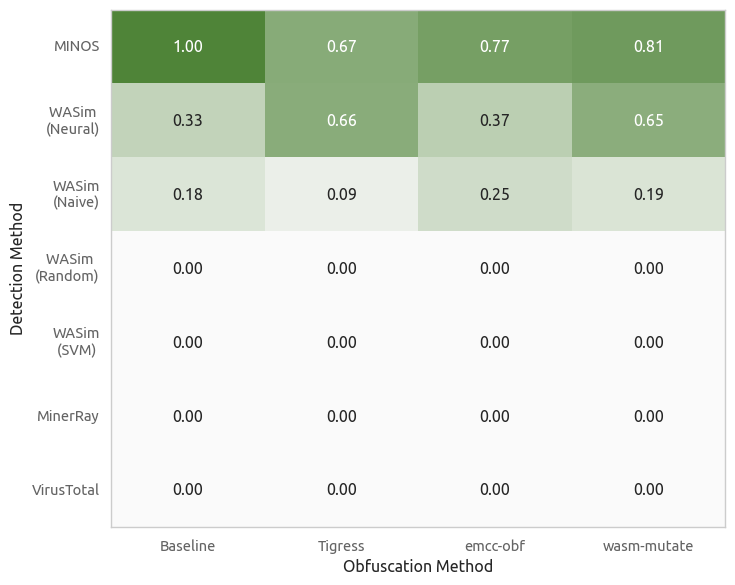

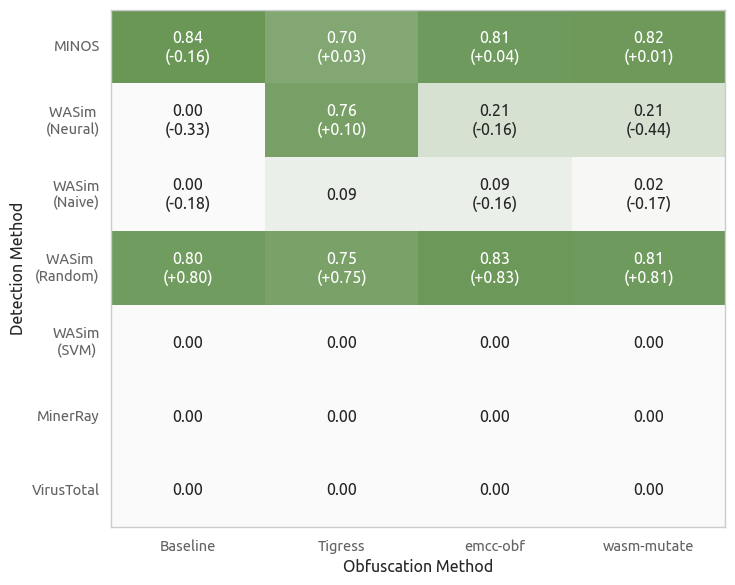

In [90]:
cmap = sns.diverging_palette(0, 120, as_cmap=True)


green_color = "#4F8438"  # Replace with your specific green HEX value
gray_color = "#fafafa"  # Replace with your specific gray HEX value

# Create a custom colormap with a linear gradient between green and gray
cmap = LinearSegmentedColormap.from_list("green_gray", [gray_color, green_color], N=256)

def plot_f1_heatmap(df, xlabels=None, ylabels=None, path=None, compare_df=None):
    plt.figure(figsize=(7.5, 6))

    ax = sns.heatmap(df, cmap=cmap, annot=True, cbar=False, fmt='.2f', vmin=0, vmax=1)
    ax.set_xlabel('Obfuscation Method')
    ax.set_ylabel('Detection Method')

    for _, spine in ax.spines.items():
        spine.set_visible(True)

    if xlabels is not None:
        ax.set_xticklabels(xlabels)

    if ylabels is not None:
        ax.set_yticklabels(ylabels)

    if compare_df is not None:
        # Calculate the difference between the two DataFrames
        diff = df - compare_df

        # Modify the existing text by iterating through the heatmap annotations
        for text in ax.texts:
            # Get the text coordinates
            x, y = map(int, text.get_position())

            # Calculate the new text
            delta = diff.iloc[y, x]
            if abs(delta) > 1e-6:  # If the difference is non-zero
                new_text = f"{df.iloc[y, x]:.2f}\n({delta:+.2f})"
            else:
                new_text = f"{df.iloc[y, x]:.2f}"

            # Update the text
            text.set_text(new_text)

    # Save plot
    if path is not None:
        plt.savefig(path, dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

xlabels = ['Baseline', 'Tigress', 'emcc-obf', 'wasm-mutate']
ylabels = ['MINOS', 'WASim \n(Neural)', 'WASim\n(Naive)', 'WASim  \n(Random)', 'WASim\n(SVM) ', 'MinerRay', 'VirusTotal']

# Call the modified function with compare_df set to the unoptimized heatmap when plotting the optimized heatmap
plot_f1_heatmap(unoptimized_heatmap, xlabels=xlabels, ylabels=ylabels, path='./plots/detectability/unoptimized-detection-heatmap.pdf')
plot_f1_heatmap(optimized_heatmap, xlabels=xlabels, ylabels=ylabels, path='./plots/detectability/optimized-detection-heatmap.pdf', compare_df=unoptimized_heatmap)



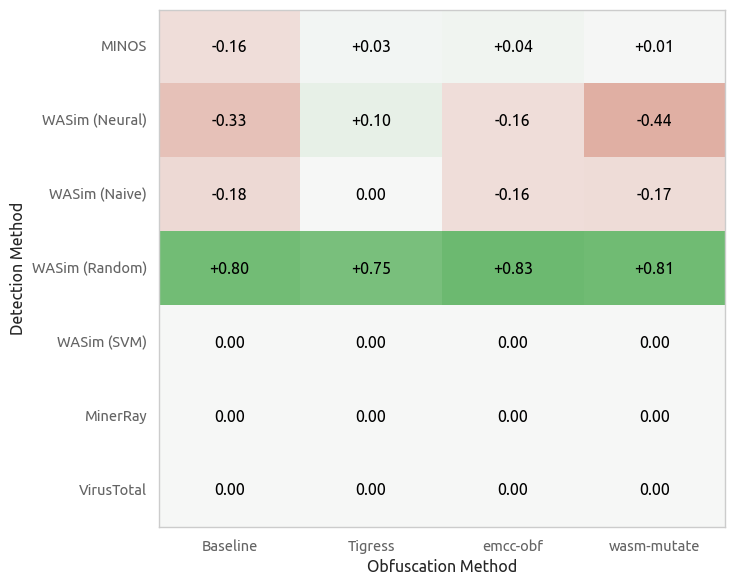

In [91]:
def custom_cmap():
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["#C3553A", "#f7f7f7", "#51ad55"])
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    return cmap, norm

def positive_number_formatter(val):
    if val > 0:
        return f"+{val:.2f}", "black"
    elif val == 0:
        return f"{val:.2f}", "black"
    else:
        return f"{val:.2f}", "black"

def plot_f1_heatmap_diff(df, xlabels=None, ylabels=None, path=None):
    plt.figure(figsize=(7.5, 6))

    cmap, norm = custom_cmap()
    ax = sns.heatmap(df, 
                     cmap=cmap, 
                     norm=norm, 
                     annot=True, 
                     cbar=False, 
                     fmt='',
                     xticklabels=xlabels,
                     yticklabels=ylabels
                       )
    for _, spine in ax.spines.items():
      spine.set_visible(True)
    
    for t in ax.texts:
        text, color = positive_number_formatter(float(t.get_text()))
        t.set_text(text)
        t.set_color(color)

    ax.set_xlabel('Obfuscation Method')
    ax.set_ylabel('Detection Method')

        # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

xlabels = ['Baseline', 'Tigress', 'emcc-obf', 'wasm-mutate']
ylabels = ['MINOS', 'WASim (Neural)', 'WASim (Naive)', 'WASim (Random)', 'WASim (SVM)', 'MinerRay', 'VirusTotal']
plot_f1_heatmap_diff(optimized_heatmap - unoptimized_heatmap, xlabels=xlabels, ylabels=ylabels, path='./plots/detectability/detection-heatmap-diff.pdf')


In [92]:
def plot_cryptominer_probability(df, model='neural', order=1, path=None):
    plt.figure(figsize=(20,5))
    # Extract 'Cryptominer' values from the 'wasim' column
    df['Cryptominer'] = df['wasim'].apply(lambda x: x['result'][model]['Cryptominer'])

    # Create a regression line plot using Seaborn
    sns.lmplot(
        x='iteration', 
        y='Cryptominer', 
        data=df,
        hue='category', 
        hue_order=['games', 'miners', 'utilities'],
        order=order,
        scatter=False, 
        line_kws={'linewidth': 2},
        palette=grb_palette,
        legend=False,
        height=5,
        aspect=1
        )

    # Set plot labels and title
    plt.ylim(0, 1)
    plt.xlim(0, 1003)
    plt.xlabel('Iteration')
    plt.ylabel('Cryptominer Prediction')
    plt.legend(title='Category')

    for text in plt.gca().get_legend().get_texts():
      text.set_text(text.get_text().capitalize())

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=500, bbox_inches="tight")

    # Show the plot
    plt.show()

/tmp/ipykernel_24729/1209527498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cryptominer'] = df['wasim'].apply(lambda x: x['result'][model]['Cryptominer'])
/home/hakon/.local/lib/python3.11/site-packages/seaborn/regression.py:254: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)
/home/hakon/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hakon/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hakon/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly 

<Figure size 2000x500 with 0 Axes>

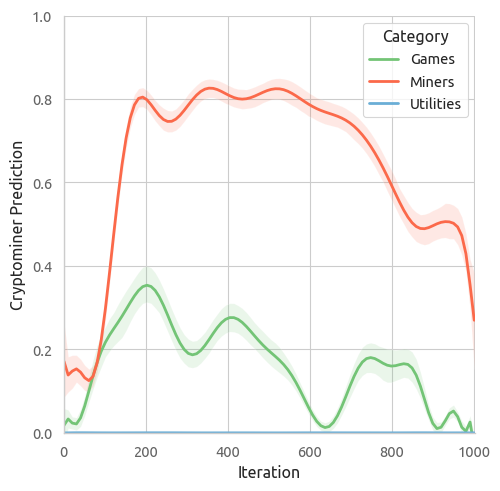

In [93]:
df = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] != -1]

plot_cryptominer_probability(df, model='neural', order=25, path='./plots/detectability/wasim-neural.pdf')
# plot_cryptominer_probability(df, model='random', order=25, path='./plots/detectability/wasim-random.pdf')
# plot_cryptominer_probability(df, model='svm', order=25, path='./plots/detectability/wasim-svm.pdf')
# plot_cryptominer_probability(df, model='naive', order=25, path='./plots/detectability/wasim-naive.pdf')

/tmp/ipykernel_24729/1209527498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cryptominer'] = df['wasim'].apply(lambda x: x['result'][model]['Cryptominer'])
/home/hakon/.local/lib/python3.11/site-packages/seaborn/regression.py:254: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)
/home/hakon/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hakon/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/hakon/.local/lib/python3.11/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly 

<Figure size 2000x500 with 0 Axes>

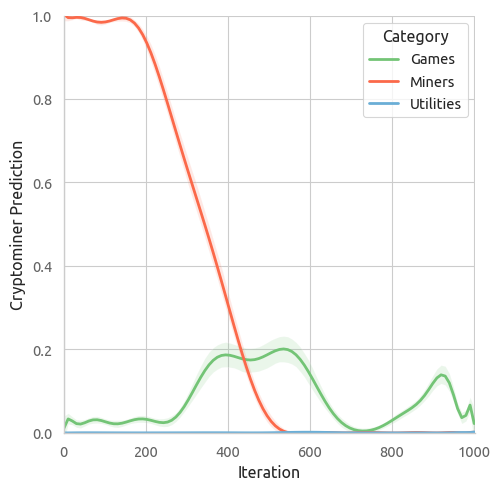

In [94]:
df = wasm_mutate_experiment[wasm_mutate_experiment['iteration'] != -1]

plot_cryptominer_probability(df, model='neural', order=25, path='./plots/detectability/wasim-neural-fn.pdf')

In [95]:
df = wasm_mutate_experiment[wasm_mutate_experiment['iteration'] != -1]
filtered_df = df[(df['category'] == 'miners') & (df['iteration'] != -1)]

# Initialize an empty dictionary to store the maximum Cryptominer value for each unique name
max_cryptominer_values = {}

# Loop through the filtered DataFrame
for index, row in filtered_df.iterrows():
    name = row['name']
    iteration = row['iteration']
    cryptominer_value = row['wasim']['result']['neural']['Cryptominer']

    # Update the maximum Cryptominer value for the current name
    if name not in max_cryptominer_values or cryptominer_value > max_cryptominer_values[name][1]:
        max_cryptominer_values[name] = (iteration, cryptominer_value)

# Print the result
for name, (iteration, value) in max_cryptominer_values.items():
    print(f"Name: {name}, Iteration: {iteration}, Cryptominer Value: {value}")

Name: cn-2, Iteration: 1, Cryptominer Value: 0.9986258745193481
Name: cn-1, Iteration: 27, Cryptominer Value: 0.9986262321472168
Name: cn-lite-0, Iteration: 3, Cryptominer Value: 0.998663067817688
Name: cn-lite-1, Iteration: 5, Cryptominer Value: 0.9986314177513123
Name: cn-half, Iteration: 2, Cryptominer Value: 0.9986745119094849
Name: cn-pico-trtl, Iteration: 24, Cryptominer Value: 0.9986264705657959
Name: cn-0, Iteration: 19, Cryptominer Value: 0.9986743927001953
Name: cn-r, Iteration: 20, Cryptominer Value: 0.9986742734909058
Name: cn-lite-2, Iteration: 45, Cryptominer Value: 0.9986742734909058
Name: cn-rwz, Iteration: 168, Cryptominer Value: 0.9983313679695129


In [96]:
df = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] != -1]
df['Cryptominer'] = df['wasim'].apply(lambda x: 
                                      x['result']['neural']['Cryptominer']
                                      )

# Group the DataFrame by 'name'
grouped = df.groupby('name')

# Calculate the difference between consecutive rows of the 'Cryptominer' column within each group
def calculate_diff(group):
    group['cryptominer_diff'] = group['Cryptominer'].diff()
    return group

# Apply the calculate_diff function to each group and combine the results into a single DataFrame
df = grouped.apply(calculate_diff)

# Fill missing values (if any) with 0
df['cryptominer_diff'].fillna(0, inplace=True)

/tmp/ipykernel_24729/776487771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cryptominer'] = df['wasim'].apply(lambda x:


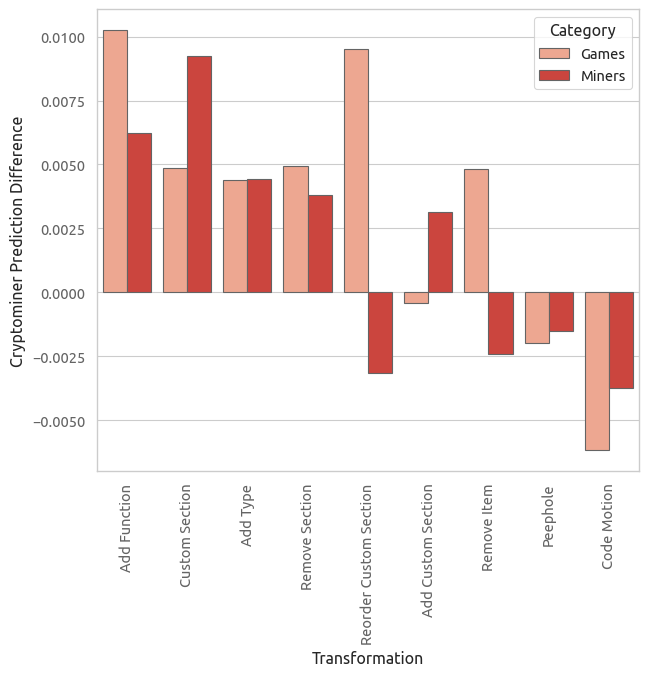

In [97]:
def plot_mutation_diff(df, palette=palette, path=None):
    df_sorted = df.groupby('transformation')['cryptominer_diff'].mean().sort_values(ascending=False)
    order = df_sorted.index

    
    plt.figure(figsize=(7,6))
    sns.barplot(data=df, 
                x='transformation', 
                y='cryptominer_diff', 
                hue='category',
                edgecolor=edgecolor,
                errorbar=None, 
                palette=palette,
                order=order,
                )
    
    # Axis labels
    plt.ylabel('Cryptominer Prediction Difference')
    plt.xlabel('Transformation')

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Category', loc='best')

    plt.xticks(rotation=90)

    for text in plt.gca().get_legend().get_texts():
      text.set_text(text.get_text().capitalize())

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

miners_only = df[df['category'] == 'miners']
games_only = df[df['category'] == 'games']

miners_and_games_only = df[df['category'] != 'utilities']

plot_mutation_diff(miners_and_games_only, palette="Reds", path='./plots/detectability/mutation-effectiveness.pdf')